#### Import libraries

In [3]:
import pandas as pd
import numpy as np
from numpy import loadtxt
from numpy import sort
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import PercentFormatter
import matplotlib.ticker as mtick
from random import sample
import seaborn as sns
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
# import onnxmltools
# from onnxmltools.convert import convert_xgboost

#### Ignore Warnings

In [4]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

#### Import Dataset

In [5]:
df_rating = pd.read_csv('dataset/corporate_rating.csv')

In [6]:
# Display the structure
df_rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2029 entries, 0 to 2028
Data columns (total 31 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Rating                              2029 non-null   object 
 1   Name                                2029 non-null   object 
 2   Symbol                              2029 non-null   object 
 3   Rating Agency Name                  2029 non-null   object 
 4   Date                                2029 non-null   object 
 5   Sector                              2029 non-null   object 
 6   currentRatio                        2029 non-null   float64
 7   quickRatio                          2029 non-null   float64
 8   cashRatio                           2029 non-null   float64
 9   daysOfSalesOutstanding              2029 non-null   float64
 10  netProfitMargin                     2029 non-null   float64
 11  pretaxProfitMargin                  2029 no

In [7]:
df_rating.head()

,Rating,Name,Symbol,Rating Agency Name,Date,Sector,currentRatio,quickRatio,cashRatio,daysOfSalesOutstanding,...,effectiveTaxRate,freeCashFlowOperatingCashFlowRatio,freeCashFlowPerShare,cashPerShare,companyEquityMultiplier,ebitPerRevenue,enterpriseValueMultiple,operatingCashFlowPerShare,operatingCashFlowSalesRatio,payablesTurnover
0,A,Whirlpool Corporation,WHR,Egan-Jones Ratings Company,11/27/2015,Consumer Durables,0.945894,0.426395,0.099690,44.203245,...,0.202716,0.437551,6.810673,9.809403,4.008012,0.049351,7.057088,15.565438,0.058638,3.906655
1,BBB,Whirlpool Corporation,WHR,Egan-Jones Ratings Company,2/13/2014,Consumer Durables,1.033559,0.498234,0.203120,38.991156,...,0.074155,0.541997,8.625473,17.402270,3.156783,0.048857,6.460618,15.914250,0.067239,4.002846
2,BBB,Whirlpool Corporation,WHR,Fitch Ratings,3/6/2015,Consumer Durables,0.963703,0.451505,0.122099,50.841385,...,0.214529,0.513185,9.693487,13.103448,4.094575,0.044334,10.491970,18.888889,0.074426,3.483510
3,BBB,Whirlpool Corporation,WHR,Fitch Ratings,6/15/2012,Consumer Durables,1.019851,0.510402,0.176116,41.161738,...,1.816667,-0.147170,-1.015625,14.440104,3.630950,-0.012858,4.080741,6.901042,0.028394,4.581150
4,BBB,Whirlpool Corporation,WHR,Standard & Poor's Ratings Services,10/24/2016,Consumer Durables,0.957844,0.495432,0.141608,47.761126,...,0.166966,0.451372,7.135348,14.257556,4.012780,0.053770,8.293505,15.808147,0.058065,3.857790


### Analyse Labels

In [8]:
df_rating.Rating.value_counts()

Rating
BBB    671
BB     490
A      398
B      302
AA      89
CCC     64
AAA      7
CC       5
C        2
D        1
Name: count, dtype: int64

In [9]:
rating_dict = {'AAA':'Lowest Risk',
               'AA':'Low Risk',
               'A':'Low Risk',
               'BBB':'Medium Risk',
               'BB':'High Risk',
               'B':'High Risk',
               'CCC':'Highest Risk',
               'CC':'Highest Risk',
               'C':'Highest Risk',
               'D':'In Default'}

df_rating.Rating = df_rating.Rating.map(rating_dict)

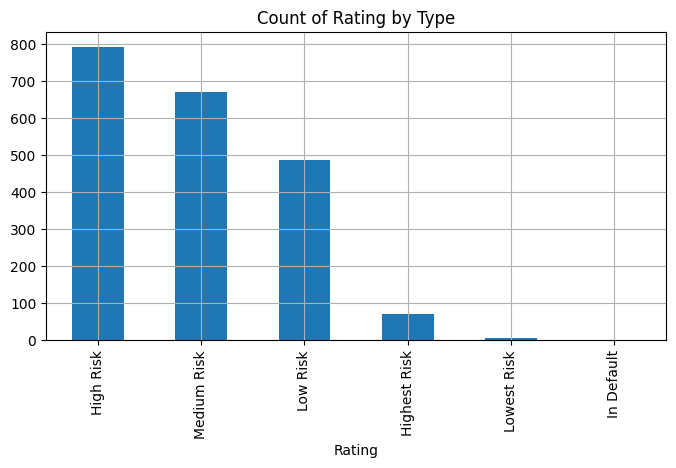

In [10]:
ax = df_rating['Rating'].value_counts().plot(kind='bar',
                                             figsize=(8,4),
                                             title="Count of Rating by Type",
                                             grid=True)

In [11]:
df_rating = df_rating[df_rating['Rating']!='Lowest Risk'] # filter Lowest Risk
df_rating = df_rating[df_rating['Rating']!='In Default']  # filter In Default
df_rating.reset_index(inplace = True, drop=True) # reset index

In [61]:
# Statistical summary
describe = df_rating.describe()
describe

,Rating,Sector,currentRatio,quickRatio,cashRatio,daysOfSalesOutstanding,netProfitMargin,pretaxProfitMargin,grossProfitMargin,operatingProfitMargin,...,effectiveTaxRate,freeCashFlowOperatingCashFlowRatio,freeCashFlowPerShare,cashPerShare,companyEquityMultiplier,ebitPerRevenue,enterpriseValueMultiple,operatingCashFlowPerShare,operatingCashFlowSalesRatio,payablesTurnover
count,2021.000000,2021.000000,2021.000000,2021.000000,2021.000000,2021.000000,2021.000000,2021.000000,2021.000000,2021.000000,...,2021.000000,2021.000000,2.021000e+03,2.021000e+03,2021.000000,2021.000000,2021.000000,2.021000e+03,2021.000000,2021.000000
mean,1.513112,4.977239,3.535411,2.657150,0.669048,334.855415,0.278725,0.432721,0.496900,0.588793,...,0.400755,0.408272,5.114871e+03,4.244248e+03,3.335166,0.438715,48.426558,6.540891e+03,1.452142,38.138233
std,1.303252,3.464598,44.139386,33.009920,3.590902,4456.606352,6.076128,9.002733,0.525996,11.246798,...,10.613711,3.803929,1.472059e+05,1.226418e+05,87.702375,9.002047,530.161001,1.778797e+05,19.521704,760.421855
min,0.000000,0.000000,-0.932005,-1.893266,-0.192736,-811.845623,-101.845815,-124.343612,-14.800817,-124.343612,...,-100.611015,-120.916010,-4.912742e+03,-1.915035e+01,-2555.419643,-124.343612,-3749.921337,-1.195049e+04,-4.461837,-76.662850
25%,0.000000,2.000000,1.071930,0.602298,0.131433,22.806507,0.020894,0.025649,0.232565,0.044546,...,0.147837,0.269616,4.094118e-01,1.562116e+00,2.050249,0.028057,6.235759,2.348851e+00,0.073664,2.202394
50%,2.000000,5.000000,1.492804,0.979094,0.297859,42.281804,0.064323,0.084965,0.414217,0.107640,...,0.300439,0.644265,2.123062e+00,3.680425e+00,2.657275,0.087424,9.269746,4.361649e+00,0.132758,5.775840
75%,3.000000,8.000000,2.160710,1.450457,0.625355,59.165369,0.113871,0.144763,0.849693,0.175334,...,0.370239,0.836949,4.230253e+00,8.027524e+00,3.665438,0.149355,12.898855,7.322553e+00,0.239359,9.500424
max,3.000000,11.000000,1725.505005,1139.541703,125.917417,115961.637400,198.517873,309.694856,2.702533,410.182214,...,429.926282,34.594086,5.753380e+06,4.786803e+06,2562.871795,309.694856,11153.607090,6.439270e+06,688.526591,20314.880400


In [76]:
pd.DataFrame([describe.loc['50%']]).to_csv("median_data.csv")

# Machine Learning 
## Prepare the Dataset

In [13]:
le = preprocessing.LabelEncoder()
le.fit(df_rating.Sector)
df_rating.Sector = le.transform(df_rating.Sector) # encode sector
le.fit(df_rating.Rating)
df_rating.Rating = le.transform(df_rating.Rating) # encode rating

In [14]:
df_train, df_test = train_test_split(df_rating, test_size=0.2, random_state = 1234)

In [15]:
X_train, y_train = df_train.iloc[:,5:31], df_train.iloc[:,0]
X_test, y_test = df_test.iloc[:,5:31], df_test.iloc[:,0]

# Fit Models

#### XGBoost

In [16]:
XGB_model = xgb.XGBRegressor(objective ='multi:softmax', num_class =4)
XGB_model.fit(X_train, y_train)
y_pred_XGB = XGB_model.predict(X_test)
Accuracy_XGB = metrics.accuracy_score(y_test, y_pred_XGB)
print("XGB Accuracy:",Accuracy_XGB)

XGB Accuracy: 0.6814814814814815


#### Gradient Boosting Classifier

In [17]:
GBT_model = GradientBoostingClassifier(random_state=123)
GBT_model.fit(X_train, y_train)
y_pred_GBT = GBT_model.predict(X_test)
Accuracy_GBT = metrics.accuracy_score(y_test, y_pred_GBT)
print("GBT Accuracy:",Accuracy_GBT)

GBT Accuracy: 0.6246913580246913


#### Random Forest

In [18]:
RF_model = RandomForestClassifier(random_state=1234)
RF_model.fit(X_train,y_train)
y_pred_RF = RF_model.predict(X_test)
Accuracy_RF = metrics.accuracy_score(y_test, y_pred_RF)
print("RF Accuracy:",Accuracy_RF)

RF Accuracy: 0.6419753086419753


#### Support Vector Machine


In [19]:
SVC_model = svm.SVC(kernel='rbf', gamma= 2, C = 5, random_state=1234)
SVC_model.fit(X_train, y_train)
y_pred_SVM = SVC_model.predict(X_test)
Accuracy_SVM = metrics.accuracy_score(y_test, y_pred_SVM)
print("SVM Accuracy:",Accuracy_SVM)

SVM Accuracy: 0.362962962962963


#### Neural Network

In [20]:
MLP_model = MLPClassifier(hidden_layer_sizes=(5,5,5), activation='logistic', solver='adam', max_iter=1500)
MLP_model.fit(X_train, y_train)
y_pred_MLP = MLP_model.predict(X_test)
Accuracy_MLP = metrics.accuracy_score(y_test, y_pred_MLP)
print("MLP Accuracy:",Accuracy_MLP)

MLP Accuracy: 0.3654320987654321


#### Naive Bayes

In [21]:
GNB_model = GaussianNB()
GNB_model.fit(X_train, y_train)
y_pred_GNB = GNB_model.predict(X_test)
Accuracy_GNB = metrics.accuracy_score(y_test, y_pred_GNB)
print("GNB Accuracy:",Accuracy_GNB)

GNB Accuracy: 0.2839506172839506


#### Linear Discriminant Analysis

In [22]:
LDA_model = LinearDiscriminantAnalysis()
LDA_model.fit(X_train,y_train)
y_pred_LDA = LDA_model.predict(X_test)
Accuracy_LDA = metrics.accuracy_score(y_test, y_pred_LDA)
print("LDA Accuracy:",Accuracy_LDA)

LDA Accuracy: 0.3950617283950617


#### Quadratic Discriminant Analysis

In [23]:
QDA_model = QuadraticDiscriminantAnalysis()
QDA_model.fit(X_train,y_train)
y_pred_QDA = QDA_model.predict(X_test)
Accuracy_QDA = metrics.accuracy_score(y_test, y_pred_QDA)
print("QDA Accuracy:",Accuracy_QDA)

QDA Accuracy: 0.2691358024691358


/home/xlager/.local/share/virtualenvs/ml-company-raiting-prediction-EUfqgbUN/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


#### K Nearest Neighbours


In [24]:
KNN_model = KNeighborsClassifier(n_neighbors = 3)
KNN_model.fit(X_train,y_train)
y_pred_KNN = KNN_model.predict(X_test)
Accuracy_KNN = metrics.accuracy_score(y_test, y_pred_KNN)
print("KNN Accuracy:",Accuracy_KNN)

KNN Accuracy: 0.562962962962963


#### Logistic Regression


In [25]:
LR_model = LogisticRegression(random_state=1234 , multi_class='multinomial', solver='newton-cg')
LR_model = LR_model.fit(X_train, y_train)
y_pred_LR = LR_model.predict(X_test)
Accuracy_LR = metrics.accuracy_score(y_test, y_pred_LR)
print("LR Accuracy:",Accuracy_LR)

LR Accuracy: 0.45185185185185184


/home/xlager/.local/share/virtualenvs/ml-company-raiting-prediction-EUfqgbUN/lib/python3.11/site-packages/sklearn/utils/optimize.py:318: ConvergenceWarning: newton-cg failed to converge at loss = 1.0562435328218027. Increase the number of iterations.
  warnings.warn(


## Compare Results

In [26]:
accuracy_list = [Accuracy_XGB, Accuracy_GBT, Accuracy_RF, Accuracy_SVM, Accuracy_MLP, Accuracy_GNB,
                 Accuracy_LDA, Accuracy_QDA, Accuracy_KNN, Accuracy_LR]

model_list = ['XGBboost', 'Gradient Boosting', 'Random Forest', 'Support Vector Machine',
              "Neural Network", 'Naive Bayes', 'Linear Discriminat', 'Quadratic Discriminat',
              'KNN', 'Logistic Regression']

df_accuracy = pd.DataFrame({'Model': model_list, 'Accuracy': accuracy_list})

/tmp/ipykernel_56014/1581507612.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(y_value)


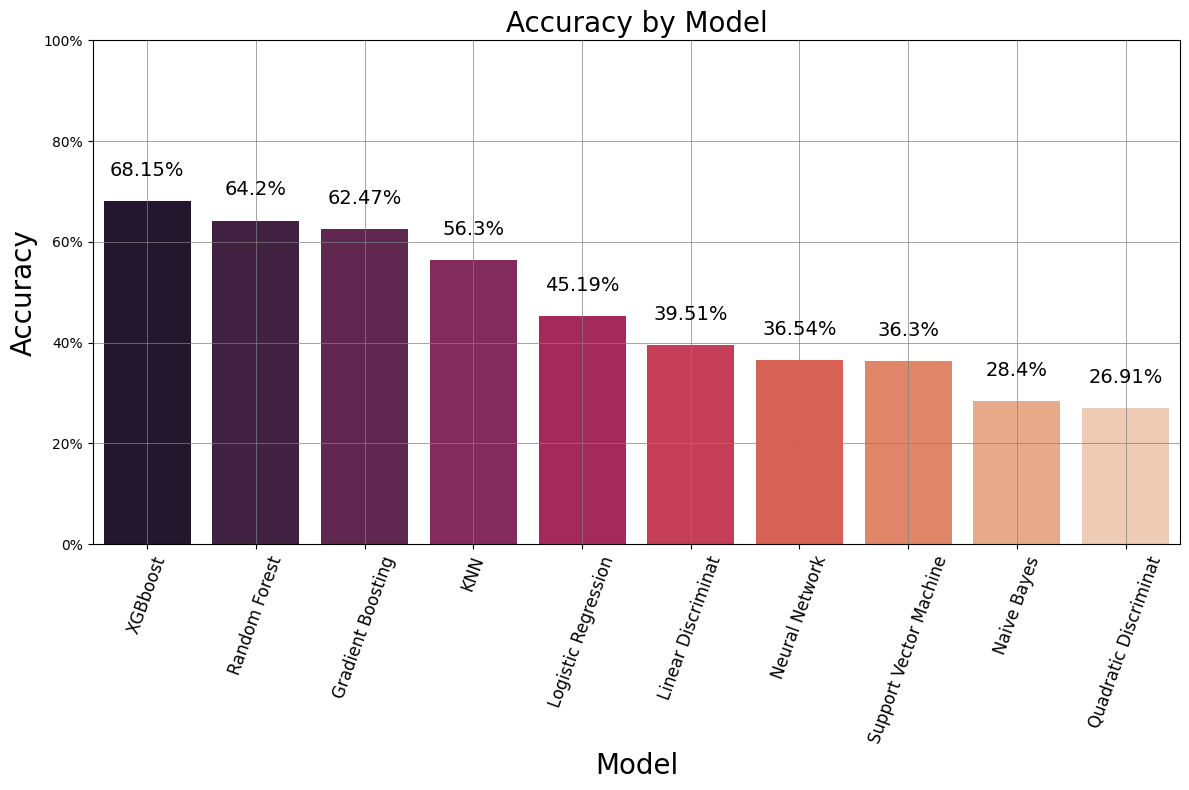

In [27]:
order = list(df_accuracy.sort_values('Accuracy', ascending=False).Model)
df_accuracy = df_accuracy.sort_values('Accuracy', ascending=False).reset_index().drop(['index'], axis=1)

plt.figure(figsize=(12,8))
# make barplot and sort bars
x = sns.barplot(x='Model', y="Accuracy", data=df_accuracy, order = order, palette="rocket")
plt.xlabel("Model", fontsize=20)
plt.ylabel("Accuracy", fontsize=20)
plt.title("Accuracy by Model", fontsize=20)
plt.grid(linestyle='-', linewidth='0.5', color='grey')
plt.xticks(rotation=70, fontsize=12)
plt.ylim(0,1)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

for i in range(len(model_list)):
    plt.text(x = i, y = df_accuracy.loc[i, 'Accuracy'] + 0.05, s = str(round((df_accuracy.loc[i, 'Accuracy'])*100, 2))+'%',
             fontsize = 14, color='black',horizontalalignment='center')

y_value=['{:,.2f}'.format(x) + '%' for x in ax.get_yticks()]
ax.set_yticklabels(y_value)

plt.tight_layout()


## XGBoost Hyperparameter Tunning

In [28]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [29]:
params = XGB_model.get_xgb_params()

In [30]:
params

{'objective': 'multi:softmax',
 'base_score': None,
 'booster': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'eval_metric': None,
 'gamma': None,
 'grow_policy': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None,
 'num_class': 4}

In [31]:
params['eval_metric'] = "merror"

In [32]:
num_boost_round = 1000

In [33]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=50,
    verbose_eval=30)

print("Best merror: {:.2f} with {} rounds".format(
                 model.best_score,
                 model.best_iteration+1))

[0]	Test-merror:0.49630


[30]	Test-merror:0.33580
[60]	Test-merror:0.32593
[90]	Test-merror:0.32593
[120]	Test-merror:0.32346
[150]	Test-merror:0.30617
[180]	Test-merror:0.31605
[200]	Test-merror:0.32099
Best merror: 0.31 with 151 rounds


In [34]:
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    seed=42,
    nfold=5,
    metrics={'merror'},
    early_stopping_rounds=50,
    verbose_eval=30
)
cv_results.tail()

[0]	train-merror:0.22973+0.01181	test-merror:0.47091+0.00890
[30]	train-merror:0.00015+0.00031	test-merror:0.36880+0.01927
[60]	train-merror:0.00000+0.00000	test-merror:0.34714+0.02675
[90]	train-merror:0.00000+0.00000	test-merror:0.34342+0.02645
[120]	train-merror:0.00000+0.00000	test-merror:0.34528+0.03376
[145]	train-merror:0.00000+0.00000	test-merror:0.34651+0.03293


,train-merror-mean,train-merror-std,test-merror-mean,test-merror-std
91,0.0,0.0,0.344653,0.028200
92,0.0,0.0,0.342797,0.026154
93,0.0,0.0,0.341563,0.026725
94,0.0,0.0,0.343416,0.028515
95,0.0,0.0,0.341561,0.028836


In [35]:
cv_results['test-merror-mean'].min()

np.float64(0.3415606008485266)

In [36]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(5,12)
    for min_child_weight in range(5,8)
]

In [37]:
# Define initial best params and MAE
min_merror = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))

    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'merror'},
        early_stopping_rounds=50,
        verbose_eval=False

    )
    # Update best merror
    mean_merror = cv_results['test-merror-mean'].min()
    boost_rounds = cv_results['test-merror-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_merror, boost_rounds))
    if mean_merror < min_merror:
        min_merror = mean_merror
        best_params = (max_depth,min_child_weight)
print("Best params: {}, {}, merror: {}".format(best_params[0], best_params[1], min_merror))

CV with max_depth=5, min_child_weight=5


	MAE 0.35333295111416885 for 114 rounds
CV with max_depth=5, min_child_weight=6
	MAE 0.3496101364522417 for 126 rounds
CV with max_depth=5, min_child_weight=7
	MAE 0.3527080227802622 for 127 rounds
CV with max_depth=6, min_child_weight=5
	MAE 0.34960249206895233 for 121 rounds
CV with max_depth=6, min_child_weight=6
	MAE 0.35333868440163585 for 50 rounds
CV with max_depth=6, min_child_weight=7
	MAE 0.3452891487979207 for 110 rounds
CV with max_depth=7, min_child_weight=5
	MAE 0.34776210679203456 for 54 rounds
CV with max_depth=7, min_child_weight=6
	MAE 0.3428047242288728 for 91 rounds
CV with max_depth=7, min_child_weight=7
	MAE 0.36137484233459466 for 43 rounds
CV with max_depth=8, min_child_weight=5
	MAE 0.3316553912013148 for 89 rounds
CV with max_depth=8, min_child_weight=6
	MAE 0.350848526545121 for 94 rounds
CV with max_depth=8, min_child_weight=7
	MAE 0.35271375606772926 for 130 rounds
CV with max_depth=9, min_child_weight=5
	MAE 0.3477544624087451 for 35 rounds
CV with max_dep

In [38]:
params['max_depth'] = 7
params['min_child_weight'] = 5

#### Parameters `subsample` and `colsample_bytree`

In [39]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(7,11)]
    for colsample in [i/10. for i in range(7,11)]
]

In [40]:
# Define initial best params and MAE
min_merror = float("Inf")
best_params = None

for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))
    # We update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample

    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'merror'},
        early_stopping_rounds=10,
        verbose_eval=False
    )

    # Update best MAE
    mean_merror = cv_results['test-merror-mean'].min()
    boost_rounds = cv_results['test-merror-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_merror, boost_rounds))
    if mean_merror < min_merror:
        min_merror = mean_merror
        best_params = (subsample,colsample)

print("Best params: {}, {}, merror: {}".format(best_params[0], best_params[1], min_merror))

CV with subsample=1.0, colsample=1.0
	MAE 0.3496139586438864 for 37 rounds
CV with subsample=1.0, colsample=0.9
	MAE 0.355807820204105 for 38 rounds
CV with subsample=1.0, colsample=0.8
	MAE 0.3551867140618431 for 29 rounds
CV with subsample=1.0, colsample=0.7
	MAE 0.3613671979513053 for 27 rounds
CV with subsample=0.9, colsample=1.0
	MAE 0.3613748423345947 for 15 rounds
CV with subsample=0.9, colsample=0.9
	MAE 0.35147345487902765 for 56 rounds
CV with subsample=0.9, colsample=0.8
	MAE 0.3533195734434124 for 32 rounds
CV with subsample=0.9, colsample=0.7
	MAE 0.3527099338760845 for 39 rounds
CV with subsample=0.8, colsample=1.0
	MAE 0.3805565111034667 for 17 rounds
CV with subsample=0.8, colsample=0.9
	MAE 0.34528532660627603 for 68 rounds
CV with subsample=0.8, colsample=0.8
	MAE 0.37377403202996595 for 11 rounds
CV with subsample=0.8, colsample=0.7
	MAE 0.34032412185146965 for 53 rounds
CV with subsample=0.7, colsample=1.0
	MAE 0.3607422696173986 for 43 rounds
CV with subsample=0.7,

In [41]:
params['subsample'] =0.9
params['colsample_bytree'] = 0.7

#### Parameter `ETA`


In [42]:
%time
# This can take some time…
min_merror = float("Inf")
best_params = None

for eta in [.3, .2, .1, .05, .01, .005]:
    print("CV with eta={}".format(eta))
    # We update our parameters
    params['eta'] = eta
    # Run and time CV
    cv_results = xgb.cv(
            params,
            dtrain,
            num_boost_round=num_boost_round,
            seed=42,
            nfold=5,
            metrics=['merror'],
            early_stopping_rounds=10
)
    # Update best score
    mean_mae = cv_results['test-merror-mean'].min()
    boost_rounds = cv_results['test-merror-mean'].argmin()
    print("\tMAE {} for {} rounds\n".format(mean_mae, boost_rounds))
    if mean_merror < min_merror:
        min_merror = mean_merror
        best_params = eta
print("Best params: {}, merror: {}".format(best_params, min_merror))

CPU times: user 4 μs, sys: 0 ns, total: 4 μs
Wall time: 6.68 μs
CV with eta=0.3
	MAE 0.3527099338760845 for 39 rounds

CV with eta=0.2
	MAE 0.35890952872377024 for 38 rounds

CV with eta=0.1
	MAE 0.3657111187554944 for 40 rounds

CV with eta=0.05
	MAE 0.37870848144325964 for 45 rounds

CV with eta=0.01
	MAE 0.39417689102931625 for 30 rounds

CV with eta=0.005
	MAE 0.3855119825708061 for 47 rounds

Best params: 0.3, merror: 0.36013263005007073


In [43]:
params['eta'] = .3

In [44]:
params

{'objective': 'multi:softmax',
 'base_score': None,
 'booster': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 0.7,
 'device': None,
 'eval_metric': 'merror',
 'gamma': None,
 'grow_policy': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 7,
 'max_leaves': None,
 'min_child_weight': 5,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': 0.9,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None,
 'num_class': 4,
 'eta': 0.3}

In [45]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=1000,
    verbose_eval=100
)

[0]	Test-merror:0.46420
[100]	Test-merror:0.31852
[200]	Test-merror:0.30864
[300]	Test-merror:0.31358
[400]	Test-merror:0.32840
[500]	Test-merror:0.33580
[600]	Test-merror:0.33580
[700]	Test-merror:0.33580
[800]	Test-merror:0.33333
[900]	Test-merror:0.33086
[999]	Test-merror:0.33086


In [46]:
num_boost_round = model.best_iteration + 1
best_model = xgb.train(
    params,
    dtrain,
    verbose_eval=100,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")]
)

[0]	Test-merror:0.46420
[100]	Test-merror:0.31852
[146]	Test-merror:0.30370


In [47]:
metrics.accuracy_score(best_model.predict(dtest), y_test)

0.6962962962962963

## Confusion Matrix

In [48]:
cm = confusion_matrix(y_test, y_pred_XGB)

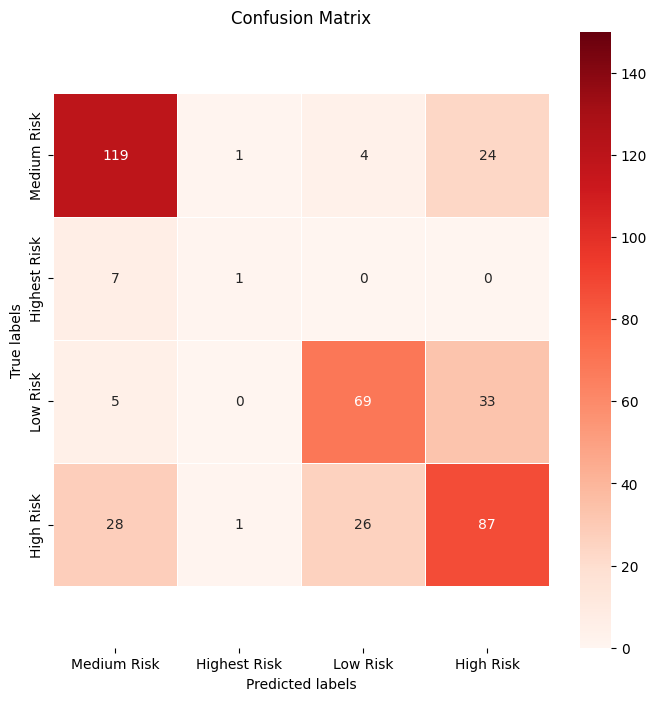

In [49]:
fig, ax = plt.subplots(figsize=(8,8))

sns.heatmap(cm, annot = True, ax = ax, vmin=0, vmax=150, fmt="d", linewidths=.5, linecolor = 'white', cmap="Reds") # annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Medium Risk','Highest Risk', 'Low Risk', 'High Risk'])
ax.yaxis.set_ticklabels(['Medium Risk','Highest Risk', 'Low Risk', 'High Risk']);

# This part is to correct a bug from the heatmap funciton from pyplot
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values

plt.show()

In [50]:
print(classification_report(y_test, y_pred_XGB, target_names = ['Medium Risk','Highest Risk', 'Low Risk', 'High Risk']))

              precision    recall  f1-score   support

 Medium Risk       0.75      0.80      0.78       148
Highest Risk       0.33      0.12      0.18         8
    Low Risk       0.70      0.64      0.67       107
   High Risk       0.60      0.61      0.61       142

    accuracy                           0.68       405
   macro avg       0.60      0.55      0.56       405
weighted avg       0.68      0.68      0.68       405



## Feature Selection

In [51]:
thresholds = sort(XGB_model.feature_importances_)
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(XGB_model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = XGBClassifier()
    selection_model.fit(select_X_train, y_train)
    # eval model
    select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_test, predictions)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

/home/xlager/.local/share/virtualenvs/ml-company-raiting-prediction-EUfqgbUN/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/xlager/.local/share/virtualenvs/ml-company-raiting-prediction-EUfqgbUN/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/xlager/.local/share/virtualenvs/ml-company-raiting-prediction-EUfqgbUN/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.022, n=26, Accuracy: 68.15%


/home/xlager/.local/share/virtualenvs/ml-company-raiting-prediction-EUfqgbUN/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/xlager/.local/share/virtualenvs/ml-company-raiting-prediction-EUfqgbUN/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.024, n=25, Accuracy: 66.67%


/home/xlager/.local/share/virtualenvs/ml-company-raiting-prediction-EUfqgbUN/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/xlager/.local/share/virtualenvs/ml-company-raiting-prediction-EUfqgbUN/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.025, n=24, Accuracy: 66.42%


/home/xlager/.local/share/virtualenvs/ml-company-raiting-prediction-EUfqgbUN/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/xlager/.local/share/virtualenvs/ml-company-raiting-prediction-EUfqgbUN/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.027, n=23, Accuracy: 68.40%


/home/xlager/.local/share/virtualenvs/ml-company-raiting-prediction-EUfqgbUN/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/xlager/.local/share/virtualenvs/ml-company-raiting-prediction-EUfqgbUN/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.028, n=22, Accuracy: 65.43%


/home/xlager/.local/share/virtualenvs/ml-company-raiting-prediction-EUfqgbUN/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/xlager/.local/share/virtualenvs/ml-company-raiting-prediction-EUfqgbUN/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.029, n=21, Accuracy: 65.93%


/home/xlager/.local/share/virtualenvs/ml-company-raiting-prediction-EUfqgbUN/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/xlager/.local/share/virtualenvs/ml-company-raiting-prediction-EUfqgbUN/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.029, n=20, Accuracy: 66.17%


/home/xlager/.local/share/virtualenvs/ml-company-raiting-prediction-EUfqgbUN/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/xlager/.local/share/virtualenvs/ml-company-raiting-prediction-EUfqgbUN/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.030, n=19, Accuracy: 64.20%


/home/xlager/.local/share/virtualenvs/ml-company-raiting-prediction-EUfqgbUN/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/xlager/.local/share/virtualenvs/ml-company-raiting-prediction-EUfqgbUN/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.030, n=18, Accuracy: 65.43%


/home/xlager/.local/share/virtualenvs/ml-company-raiting-prediction-EUfqgbUN/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/xlager/.local/share/virtualenvs/ml-company-raiting-prediction-EUfqgbUN/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.033, n=17, Accuracy: 64.94%


/home/xlager/.local/share/virtualenvs/ml-company-raiting-prediction-EUfqgbUN/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/xlager/.local/share/virtualenvs/ml-company-raiting-prediction-EUfqgbUN/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.034, n=16, Accuracy: 63.46%


/home/xlager/.local/share/virtualenvs/ml-company-raiting-prediction-EUfqgbUN/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/xlager/.local/share/virtualenvs/ml-company-raiting-prediction-EUfqgbUN/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.034, n=15, Accuracy: 64.44%


/home/xlager/.local/share/virtualenvs/ml-company-raiting-prediction-EUfqgbUN/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/xlager/.local/share/virtualenvs/ml-company-raiting-prediction-EUfqgbUN/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.034, n=14, Accuracy: 63.21%


/home/xlager/.local/share/virtualenvs/ml-company-raiting-prediction-EUfqgbUN/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/xlager/.local/share/virtualenvs/ml-company-raiting-prediction-EUfqgbUN/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.035, n=13, Accuracy: 65.43%


/home/xlager/.local/share/virtualenvs/ml-company-raiting-prediction-EUfqgbUN/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/xlager/.local/share/virtualenvs/ml-company-raiting-prediction-EUfqgbUN/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.036, n=12, Accuracy: 63.46%


/home/xlager/.local/share/virtualenvs/ml-company-raiting-prediction-EUfqgbUN/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/xlager/.local/share/virtualenvs/ml-company-raiting-prediction-EUfqgbUN/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.036, n=11, Accuracy: 61.23%


/home/xlager/.local/share/virtualenvs/ml-company-raiting-prediction-EUfqgbUN/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/xlager/.local/share/virtualenvs/ml-company-raiting-prediction-EUfqgbUN/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.037, n=10, Accuracy: 61.48%


/home/xlager/.local/share/virtualenvs/ml-company-raiting-prediction-EUfqgbUN/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/xlager/.local/share/virtualenvs/ml-company-raiting-prediction-EUfqgbUN/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.037, n=9, Accuracy: 60.99%


/home/xlager/.local/share/virtualenvs/ml-company-raiting-prediction-EUfqgbUN/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/xlager/.local/share/virtualenvs/ml-company-raiting-prediction-EUfqgbUN/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.038, n=8, Accuracy: 59.26%


/home/xlager/.local/share/virtualenvs/ml-company-raiting-prediction-EUfqgbUN/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/xlager/.local/share/virtualenvs/ml-company-raiting-prediction-EUfqgbUN/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.041, n=7, Accuracy: 57.78%


/home/xlager/.local/share/virtualenvs/ml-company-raiting-prediction-EUfqgbUN/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/xlager/.local/share/virtualenvs/ml-company-raiting-prediction-EUfqgbUN/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.042, n=6, Accuracy: 55.56%


/home/xlager/.local/share/virtualenvs/ml-company-raiting-prediction-EUfqgbUN/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/xlager/.local/share/virtualenvs/ml-company-raiting-prediction-EUfqgbUN/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.052, n=5, Accuracy: 49.63%


/home/xlager/.local/share/virtualenvs/ml-company-raiting-prediction-EUfqgbUN/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/xlager/.local/share/virtualenvs/ml-company-raiting-prediction-EUfqgbUN/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.058, n=4, Accuracy: 49.38%


/home/xlager/.local/share/virtualenvs/ml-company-raiting-prediction-EUfqgbUN/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/xlager/.local/share/virtualenvs/ml-company-raiting-prediction-EUfqgbUN/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.070, n=3, Accuracy: 44.69%


/home/xlager/.local/share/virtualenvs/ml-company-raiting-prediction-EUfqgbUN/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/xlager/.local/share/virtualenvs/ml-company-raiting-prediction-EUfqgbUN/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.071, n=2, Accuracy: 43.95%
Thresh=0.072, n=1, Accuracy: 41.73%


/home/xlager/.local/share/virtualenvs/ml-company-raiting-prediction-EUfqgbUN/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


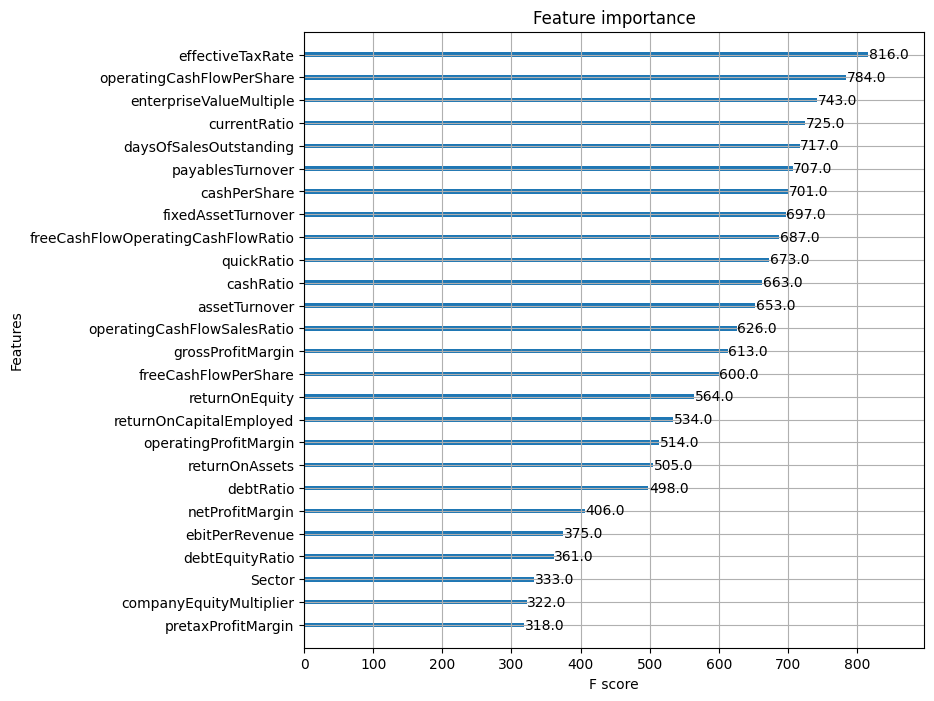

In [52]:
from xgboost import plot_importance

fig, ax = plt.subplots(figsize=(8, 8))
# xgboost.plot_importance(..., ax=ax)

plot_importance(model, ax=ax)
plt.show()

# Dump model

In [ ]:
# from onnxmltools.common.data_types import *

In [54]:
# dump = model.get_dump()

# onnx_model = convert_xgboost(model)

# onnxmltools.utils.save_model(onnx_model, "rating-prediction.onnx")

# onnx_model = onnxmltools.convert_lightgbm(lgb_model, initial_types=[(variable_name, data_type), (variable_name, data_type)])

# # Save as protobuf
# onnxmltools.utils.save_model(onnx_model, output_onnx_model)


ValueError: Initial types are required. See usage of convert(...) in                            onnxmltools.convert.xgboost.convert for details

In [56]:
# model.save_model("rating-prediction.json")

In [57]:
# onnx_model = xgb.to_onnx(model, input_name='input', output_name='output')

# # Save the ONNX model to a file
# with open('rating-prediction.onnx', 'wb') as f:
#     f.write(onnx_model.SerializeToString())

AttributeError: module 'xgboost' has no attribute 'to_onnx'